<a href="https://colab.research.google.com/github/lerdeljan17/ML-Homework-1/blob/main/3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3A**

---



---



In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

Test example: 1/20| Predicted: 0| Actual: 0| Match: True
Test example: 11/20| Predicted: 1| Actual: 0| Match: False
12 matches out of 20 examples
Test set accuracy:  0.6
0 matches out of 158100 examples


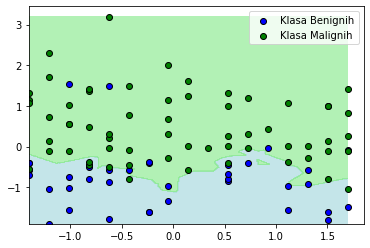

In [ ]:
class KNN:
  
  def __init__(self, nb_features, nb_classes, data, k):
    self.nb_features = nb_features
    self.nb_classes = nb_classes
    self.data = data
    self.k = k
    
    # Gradimo model, X je matrica podataka a Q je vektor koji predstavlja upit.
    self.X = tf.placeholder(shape=(None, nb_features), dtype=tf.float32)
    self.Y = tf.placeholder(shape=(None), dtype=tf.int32)
    self.Q = tf.placeholder(shape=(nb_features), dtype=tf.float32)
    
    # Racunamo kvadriranu euklidsku udaljenost i uzimamo minimalnih k.
    dists = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.X, self.Q)), 
                                  axis=1))
    _, idxs = tf.nn.top_k(-dists, self.k)  
    
    self.classes = tf.gather(self.Y, idxs)
    self.dists = tf.gather(dists, idxs)
    
    self.w = tf.fill([k], 1/k)
    
    # Svaki red mnozimo svojim glasom i sabiramo glasove po kolonama.
    w_col = tf.reshape(self.w, (k, 1))
    self.classes_one_hot = tf.one_hot(self.classes, nb_classes)
    self.scores = tf.reduce_sum(w_col * self.classes_one_hot, axis=0)
    
    # Klasa sa najvise glasova je hipoteza.
    self.hyp = tf.argmax(self.scores)
  
  # Ako imamo odgovore za upit racunamo i accuracy.
  def predict(self, query_data):
    
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      nb_queries = query_data['x'].shape[0]
      
      # Pokretanje na svih 10000 primera bi trajalo predugo,
      # pa pokrecemo samo prvih 100.
      #nb_queries = 100
      
      matches = 0
      predicted = []
      for i in range(nb_queries):
        hyp_val = sess.run(self.hyp, feed_dict = {self.X: self.data['x'], 
                                                  self.Y: self.data['y'], 
                                                 self.Q: query_data['x'][i]})
        predicted.append(hyp_val)
        if query_data['y'] is not None:
          actual = query_data['y'][i]
          match = (hyp_val == actual)
          if match:
            matches += 1
          if i % 10 == 0:
            print('Test example: {}/{}| Predicted: {}| Actual: {}| Match: {}'
                 .format(i+1, nb_queries, hyp_val, actual, match))
      '''
      saver = tf.train.Saver()
      saver.save(sess, '/tmp/log_reg.ckpt')
      print('Checkpoint sacuvan')
      '''
      accuracy = matches / nb_queries
      print('{} matches out of {} examples'.format(matches, nb_queries))
      
      return accuracy,predicted



tf.reset_default_graph()

# Korak 1: Učitavanje i obrada podataka.
filename = '/content/drive/My Drive/ML/ml_d1_x_y_z/data/Prostate_Cancer.csv'
all_data = pd.read_csv(filename,usecols=(1,3,4))#najbolje bilo za 3,4
all_data.diagnosis_result = [1 if each == "M" else 0 for each in all_data.diagnosis_result]

data = dict()
#print(all_data)
data['y'] =  all_data.diagnosis_result.values
#print(data['y'])
all_data.drop(['diagnosis_result'], axis=1)
data['x'] =  all_data.drop(['diagnosis_result'], axis=1).values
#print(data['x'])
nb_features = 2
nb_classes = 2

# Nasumično mešanje.
nb_samples = data['x'].shape[0]
indices = np.random.permutation(nb_samples)
data['x'] = data['x'][indices]
data['y'] = data['y'][indices]

# Normalizacija. Ne normalizujemo y!
data['x'] = (data['x'] - np.mean(data['x'], axis=0)) / np.std(data['x'], axis=0)
# data['y'] = (data['y'] - np.mean(data['y'])) / np.std(data['y'])

# Podela na trening i test skup. Preskačemo validacioni skup jer imamo samo 
# jedan model.
train_ratio = 0.8

nb_train = int(train_ratio * nb_samples)
data_train = dict()
data_train['x'] = data['x'][:nb_train]
data_train['y'] = data['y'][:nb_train]

nb_test = nb_samples - nb_train
data_test = dict()
data_test['x'] = data['x'][nb_train:]
data_test['y'] = data['y'][nb_train:]

'''
data['x'] = all_data[:, : ]
classData = np.loadtxt(filename, delimiter=',', usecols=(1),skiprows=1,dtype=np.str)
data['y'] = classData[:]
print(data['x'])
print(data['y'])
nb_features = 2
nb_classes = 2
'''
'''
# Iscrtavanje.
idxs = data_train['y'] == 0.0
plt.scatter(data_train['x'][idxs, 0], data_train['x'][idxs, 1], c='b', 
            edgecolors='k', label='B')
plt.scatter(data_train['x'][~idxs, 0], data_train['x'][~idxs, 1], c='m', 
            edgecolors='k', label='M')
plt.legend()
plt.show()
'''
# Pokrecemo kNN na test skupu.
nb_features = 2
nb_classes = 2
k = 3
train_data = {'x': data_train['x'], 'y': data_train['y']}
knn = KNN(nb_features, nb_classes, train_data, k)
accuracy,predicted = knn.predict({'x': data_test['x'], 'y': data_test['y']})
print('Test set accuracy: ', accuracy)

# Generisemo grid.
step_size = 0.01
x1, x2 = np.meshgrid(np.arange(min(data['x'][:, 0]), max(data['x'][:, 0]),
                                step_size),
                      np.arange(min(data['x'][:, 1]), max(data['x'][:, 1]),
                                step_size))
x_feed = np.vstack((x1.flatten(), x2.flatten())).T
# Racunamo vrednost hipoteze.
accuracy, pred_val = knn.predict({'x': x_feed, 'y': None})
# pred_val = sess.run(pred, feed_dict={X: x_feed})

pred_val = np.array(pred_val)
pred_plot = pred_val.reshape([x1.shape[0], x1.shape[1]])

# Crtamo contour plot.
from matplotlib.colors import LinearSegmentedColormap
classes_cmap = LinearSegmentedColormap.from_list('classes_cmap', 
                                                  ['lightblue', 
                                                  'lightgreen']
                                                 )
plt.contourf(x1, x2, pred_plot, cmap=classes_cmap, alpha=0.7)

# Crtamo sve podatke preko.
idxs_0 = data['y'] == 0.0
idxs_1 = data['y'] == 1.0

plt.scatter(data['x'][idxs_0, 0], data['x'][idxs_0, 1], c='b', 
              edgecolors='k', label='Klasa Benignih')
plt.scatter(data['x'][idxs_1, 0], data['x'][idxs_1, 1], c='g', 
            edgecolors='k', label='Klasa Malignih')
plt.legend()
plt.show()

# **3B**

---



---



Test example: 1/20| Predicted: 1| Actual: 1| Match: True
Test example: 11/20| Predicted: 1| Actual: 1| Match: True
15 matches out of 20 examples
Test example: 1/20| Predicted: 1| Actual: 1| Match: True
Test example: 11/20| Predicted: 1| Actual: 1| Match: True
15 matches out of 20 examples
Test example: 1/20| Predicted: 1| Actual: 1| Match: True
Test example: 11/20| Predicted: 1| Actual: 1| Match: True
18 matches out of 20 examples
Test example: 1/20| Predicted: 0| Actual: 1| Match: False
Test example: 11/20| Predicted: 1| Actual: 1| Match: True
16 matches out of 20 examples
Test example: 1/20| Predicted: 1| Actual: 1| Match: True
Test example: 11/20| Predicted: 1| Actual: 1| Match: True
18 matches out of 20 examples
Test example: 1/20| Predicted: 0| Actual: 1| Match: False
Test example: 11/20| Predicted: 1| Actual: 1| Match: True
17 matches out of 20 examples
Test example: 1/20| Predicted: 1| Actual: 1| Match: True
Test example: 11/20| Predicted: 1| Actual: 1| Match: True
17 matches ou

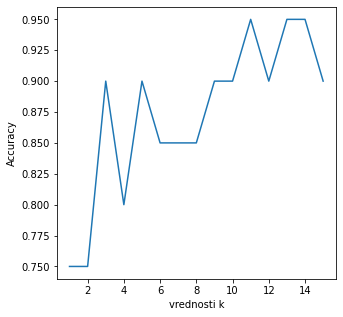

In [ ]:
class KNN:
  
  def __init__(self, nb_features, nb_classes, data, k):
    self.nb_features = nb_features
    self.nb_classes = nb_classes
    self.data = data
    self.k = k
    
    # Gradimo model, X je matrica podataka a Q je vektor koji predstavlja upit.
    self.X = tf.placeholder(shape=(None, nb_features), dtype=tf.float32)
    self.Y = tf.placeholder(shape=(None), dtype=tf.int32)
    self.Q = tf.placeholder(shape=(nb_features), dtype=tf.float32)
    
    # Racunamo kvadriranu euklidsku udaljenost i uzimamo minimalnih k.
    dists = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.X, self.Q)), 
                                  axis=1))
    _, idxs = tf.nn.top_k(-dists, self.k)  
    
    self.classes = tf.gather(self.Y, idxs)
    self.dists = tf.gather(dists, idxs)
    
    self.w = tf.fill([k], 1/k)
    
    # Svaki red mnozimo svojim glasom i sabiramo glasove po kolonama.
    w_col = tf.reshape(self.w, (k, 1))
    self.classes_one_hot = tf.one_hot(self.classes, nb_classes)
    self.scores = tf.reduce_sum(w_col * self.classes_one_hot, axis=0)
    
    # Klasa sa najvise glasova je hipoteza.
    self.hyp = tf.argmax(self.scores)
  
  # Ako imamo odgovore za upit racunamo i accuracy.
  def predict(self, query_data):
    
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      nb_queries = query_data['x'].shape[0]
      
      # Pokretanje na svih 10000 primera bi trajalo predugo,
      # pa pokrecemo samo prvih 100.
      #nb_queries = 100
      
      matches = 0
      predicted = []
      for i in range(nb_queries):
        hyp_val = sess.run(self.hyp, feed_dict = {self.X: self.data['x'], 
                                                  self.Y: self.data['y'], 
                                                 self.Q: query_data['x'][i]})
        predicted.append(hyp_val)
        if query_data['y'] is not None:
          actual = query_data['y'][i]
          match = (hyp_val == actual)
          if match:
            matches += 1
          if i % 10 == 0:
           print('Test example: {}/{}| Predicted: {}| Actual: {}| Match: {}'
                .format(i+1, nb_queries, hyp_val, actual, match))
      '''
      saver = tf.train.Saver()
      saver.save(sess, '/tmp/log_reg.ckpt')
      print('Checkpoint sacuvan')
      '''
      accuracy = matches / nb_queries
      print('{} matches out of {} examples'.format(matches, nb_queries))
      
      return accuracy,predicted



tf.reset_default_graph()

# Korak 1: Učitavanje i obrada podataka.
filename = '/content/drive/My Drive/ML/ml_d1_x_y_z/data/Prostate_Cancer.csv'
all_data = pd.read_csv(filename,usecols=(1,2,3,4,5))
all_data.diagnosis_result = [1 if each == "M" else 0 for each in all_data.diagnosis_result]

data = dict()
#print(all_data)
data['y'] =  all_data.diagnosis_result.values
#print(data['y'])
all_data.drop(['diagnosis_result'], axis=1)
data['x'] =  all_data.drop(['diagnosis_result'], axis=1).values
#print(data['x'])
nb_features = 4
nb_classes = 2

# Nasumično mešanje.
nb_samples = data['x'].shape[0]
indices = np.random.permutation(nb_samples)
data['x'] = data['x'][indices]
data['y'] = data['y'][indices]

# Normalizacija. Ne normalizujemo y!
data['x'] = (data['x'] - np.mean(data['x'], axis=0)) / np.std(data['x'], axis=0)
# data['y'] = (data['y'] - np.mean(data['y'])) / np.std(data['y'])

# Podela na trening i test skup. Preskačemo validacioni skup jer imamo samo 
# jedan model.
train_ratio = 0.8

nb_train = int(train_ratio * nb_samples)
data_train = dict()
data_train['x'] = data['x'][:nb_train]
data_train['y'] = data['y'][:nb_train]

nb_test = nb_samples - nb_train
data_test = dict()
data_test['x'] = data['x'][nb_train:]
data_test['y'] = data['y'][nb_train:]

# Pokrecemo kNN na test skupu.
nb_features = 4
nb_classes = 2
accPerK = dict()
for k in range(1,16):
  #tf.reset_default_graph()
  train_data = {'x': data_train['x'], 'y': data_train['y']}
  knn = KNN(nb_features, nb_classes, train_data, k)
  accuracy,predicted = knn.predict({'x': data_test['x'], 'y': data_test['y']})
  accPerK[k] = accuracy
  #print('Test set accuracy: ', accuracy)

#plotujemo
print(accPerK)
plt.figure(figsize=(5, 5))
x=[]
y=[]
for i in accPerK.keys():
  x.append(i)
for i in accPerK.values():
  y.append(i)
plt.plot(x,y)
plt.xlabel('vrednosti k')
plt.ylabel('Accuracy')
plt.show
print('Najbolji k{} sa acc:{}'.format([k for (k, v) in accPerK.items() if v == max(accPerK.values())],max(accPerK.values())))

#Vise puta pokrenut program je pokazao da uglavom acc varira izmedju 0.6 i 0.8
#retko je preko 0.8, najveci primecen je 0.95
#uglavnom za k vece od 2 su slicni acc i veci od onog za k = 2
#grafik se menja cini se poprilicno random

# **3C**

---



---



Test example: 1/20| Predicted: 0| Actual: 1| Match: False
Test example: 11/20| Predicted: 0| Actual: 1| Match: False
4 matches out of 20 examples
Test example: 1/20| Predicted: 0| Actual: 1| Match: False
Test example: 11/20| Predicted: 0| Actual: 1| Match: False
4 matches out of 20 examples
Test example: 1/20| Predicted: 1| Actual: 1| Match: True
Test example: 11/20| Predicted: 1| Actual: 1| Match: True
16 matches out of 20 examples
Test example: 1/20| Predicted: 0| Actual: 1| Match: False
Test example: 11/20| Predicted: 0| Actual: 1| Match: False
4 matches out of 20 examples
Test example: 1/20| Predicted: 0| Actual: 1| Match: False
Test example: 11/20| Predicted: 0| Actual: 1| Match: False
4 matches out of 20 examples
Test example: 1/20| Predicted: 0| Actual: 1| Match: False
Test example: 11/20| Predicted: 0| Actual: 1| Match: False
4 matches out of 20 examples
Test example: 1/20| Predicted: 0| Actual: 1| Match: False
Test example: 11/20| Predicted: 0| Actual: 1| Match: False
4 matche

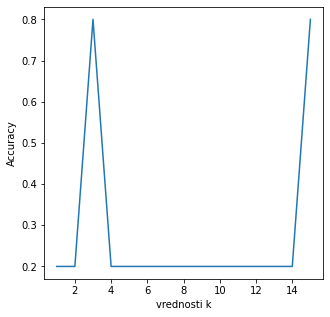

In [ ]:
tf.reset_default_graph()
class KNN:
  
  def __init__(self, nb_features, nb_classes, data, k):
    self.nb_features = nb_features
    self.nb_classes = nb_classes
    self.data = data
    self.k = k
    
    # Gradimo model, X je matrica podataka a Q je vektor koji predstavlja upit.
    self.X = tf.placeholder(shape=(None, nb_features), dtype=tf.float32)
    self.Y = tf.placeholder(shape=(None), dtype=tf.int32)
    self.Q = tf.placeholder(shape=(nb_features), dtype=tf.float32)
    
    # Racunamo kvadriranu euklidsku udaljenost i uzimamo minimalnih k.
    dists = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.X, self.Q)), 
                                  axis=1))
    _, idxs = tf.nn.top_k(-dists, self.k)  
    
    self.classes = tf.gather(self.Y, idxs)
    self.dists = tf.gather(dists, idxs)
    
    self.w = tf.fill([k], 1/k)
    
    # Svaki red mnozimo svojim glasom i sabiramo glasove po kolonama.
    w_col = tf.reshape(self.w, (k, 1))
    self.classes_one_hot = tf.one_hot(self.classes, nb_classes)
    self.scores = tf.reduce_sum(w_col * self.classes_one_hot, axis=0)
    
    # Klasa sa najvise glasova je hipoteza.
    self.hyp = tf.argmax(self.scores)
  
  # Ako imamo odgovore za upit racunamo i accuracy.
  def predict(self, query_data):
    
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      nb_queries = query_data['x'].shape[0]
      
      # Pokretanje na svih 10000 primera bi trajalo predugo,
      # pa pokrecemo samo prvih 100.
      #nb_queries = 100
      
      matches = 0
      for i in range(nb_queries):
        hyp_val = sess.run(self.hyp, feed_dict = {self.X: self.data['x'], 
                                                  self.Y: self.data['y'], 
                                                 self.Q: query_data['x'][i]})
        if query_data['y'] is not None:
          actual = query_data['y'][i]
          match = (int(hyp_val) == int(actual))
          if match:
            matches += 1
          if i % 10 == 0:
           print('Test example: {}/{}| Predicted: {}| Actual: {}| Match: {}'
                .format(i+1, nb_queries, hyp_val, actual, match))
      '''
      saver = tf.train.Saver()
      saver.save(sess, '/tmp/log_reg.ckpt')
      print('Checkpoint sacuvan')
      '''
      accuracy = matches / nb_queries
      print('{} matches out of {} examples'.format(matches, nb_queries))
      
      return accuracy





# Korak 1: Učitavanje i obrada podataka.
filename = '/content/drive/My Drive/ML/ml_d1_x_y_z/data/Prostate_Cancer.csv'
all_data = pd.read_csv(filename,usecols=(1,2,3,4,5,6,7,8,9))
all_data.diagnosis_result = [1 if each == "M" else 0 for each in all_data.diagnosis_result]

data = dict()
#print(all_data)
data['y'] =  all_data.diagnosis_result.values
#print(data['y'])
all_data.drop(['diagnosis_result'], axis=1)
data['x'] =  all_data.drop(['diagnosis_result'], axis=1).values
#print(data['x'])
nb_features = 8
nb_classes = 2

# Nasumično mešanje.
nb_samples = data['x'].shape[0]
indices = np.random.permutation(nb_samples)
data['x'] = data['x'][indices]
data['y'] = data['y'][indices]

# Normalizacija. Ne normalizujemo y!
data['x'] = (data['x'] - np.mean(data['x'], axis=0)) / np.std(data['x'], axis=0)

# Podela na trening i test skup. Preskačemo validacioni skup jer imamo samo 
# jedan model.
train_ratio = 0.8

nb_train = int(train_ratio * nb_samples)
data_train = dict()
data_train['x'] = data['x'][:nb_train]
data_train['y'] = data['y'][:nb_train]

nb_test = nb_samples - nb_train
data_test = dict()
data_test['x'] = data['x'][nb_train:]
data_test['y'] = data['y'][nb_train:]

# Pokrecemo kNN na test skupu.
nb_features = 8
nb_classes = 2
accPerK = dict()
for k in range(1,16):
  #tf.reset_default_graph()
  train_data = {'x': data_train['x'], 'y': data_train['y']}
  knn = KNN(nb_features, nb_classes, train_data, k)
  accuracy = knn.predict({'x': data_test['x'], 'y': data_test['y']})
  accPerK[k] = accuracy
  #print('Test set accuracy: ', accuracy)

#plotujemo
print(accPerK)
plt.figure(figsize=(5, 5))
x=[]
y=[]
for i in accPerK.keys():
  x.append(i)
for i in accPerK.values():
  y.append(i)
plt.plot(x,y)
plt.xlabel('vrednosti k')
plt.ylabel('Accuracy')
plt.show
print('Najbolji k{} sa acc:{}'.format([k for (k, v) in accPerK.items() if v == max(accPerK.values())],max(accPerK.values())))
# opseg variranja accuracy-ja je dosta manji